#### Loading the formatter

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

#### Loading the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import tensorflow as tf
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow import keras

# from kerastuner.tuners import RandomSearch
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# from kerastuner import RandomSearch
# from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.callbacks import EarlyStopping

np.set_printoptions(precision=3, suppress=True)

<IPython.core.display.Javascript object>

In [3]:
# Loading the data from CSV files
df_100 = pd.read_csv("Data/leakage_dataset_train_100.csv", header=0)
df_1000 = pd.read_csv("Data/leakage_dataset_train_1000.csv", header=0)
df_val = pd.read_csv("Data/leakage_dataset_validation_1000.csv", header=0)

<IPython.core.display.Javascript object>

In [4]:
# Load the features and label from dataframe and convert it to numpy array

y_train_100 = df_100[['y1', 'y2']].to_numpy()
X_train_100 = df_100[['mfc1', 'mfc2', 'mfc3', 'mfc4']].to_numpy()

y_train_1000 = df_1000[['y1', 'y2']].to_numpy()
X_train_1000 = df_1000[['mfc1', 'mfc2', 'mfc3', 'mfc4']].to_numpy()

y_val = df_val[['y1', 'y2']].to_numpy()
X_val = df_val[['mfc1', 'mfc2', 'mfc3', 'mfc4']].to_numpy()


<IPython.core.display.Javascript object>

In [17]:
def augment_data(x_train, y_train):

    x_train_aug = []
    y_train_aug = []

    for i in range(len(x_train)):
        x_train_aug.append(x_train[i])
        y_train_aug.append(y_train[i])

        # 90 degree clockwise rotation
        x_train_aug.append(
            np.flip(
                np.array([-x_train[i][1], x_train[i][0], -x_train[i][3], x_train[i][2]])
            )
        )
        y_train_aug.append(np.flip(np.array([y_train[i][1], -y_train[i][0]])))

        # 180 degree clockwise rotation
        x_train_aug.append(
            np.flip(
                np.array([-x_train[i][2], -x_train[i][3], x_train[i][0], x_train[i][1]])
            )
        )
        y_train_aug.append(np.flip(np.array([-y_train[i][0], -y_train[i][1]])))

        # 270 degree clockwise rotation
        x_train_aug.append(
            np.flip(
                np.array([x_train[i][3], -x_train[i][2], x_train[i][1], -x_train[i][0]])
            )
        )
        y_train_aug.append(np.flip(np.array([-y_train[i][1], y_train[i][0]])))

        # vertical flip
        x_train_aug.append(
            np.flip(
                np.array([x_train[i][2], x_train[i][3], x_train[i][0], x_train[i][1]])
            )
        )
        y_train_aug.append(np.flip(np.array([-y_train[i][0], y_train[i][1]])))

        # horizontal flip + 90 degree clockwise rotation
        x_train_aug.append(
            np.flip(
                np.array(
                    [-x_train[i][1], -x_train[i][0], -x_train[i][3], -x_train[i][2]]
                )
            )
        )
        y_train_aug.append(np.flip(np.array([-y_train[i][1], y_train[i][0]])))

        # horizontal flip + 180 degree clockwise rotation
        x_train_aug.append(
            np.flip(
                np.array([-x_train[i][2], -x_train[i][1], x_train[i][0], x_train[i][3]])
            )
        )
        y_train_aug.append(np.flip(np.array([y_train[i][0], y_train[i][1]])))

        # horizontal flip + 270 degree clockwise rotation
        x_train_aug.append(
            np.flip(
                np.array([x_train[i][3], x_train[i][2], -x_train[i][1], x_train[i][0]])
            )
        )
        y_train_aug.append(np.flip(np.array([y_train[i][1], -y_train[i][0]])))
    return x_train_aug, y_train_aug

<IPython.core.display.Javascript object>

In [ ]:
### Model 1

# Define the Keras model
def build_model_1(hp):
    model = Sequential()
    model.add(
        Dense(
            units=hp.Int("units_1", min_value=32, max_value=128, step=16),
            input_shape=(4,),
            activation=hp.Choice("activation", values=["relu", "tanh", "sigmoid"]),
        )
    )
    model.add(Dropout(hp.Float("dropout_1", min_value=0.0, max_value=0.5, step=0.1)))
    model.add(
        Dense(
            units=hp.Int("units_2", min_value=16, max_value=64, step=16),
            activation=hp.Choice("activation", values=["relu", "tanh", "sigmoid"]),
        )
    )
    model.add(Dropout(hp.Float("dropout_2", min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(2, activation="softmax"))

    # Set optimizer and learning rate
    optimizer = hp.Choice("optimizer", values=["adam", "rmsprop"])
    learning_rate = hp.Choice("learning_rate", values=[0.001, 0.01, 0.1])
    if optimizer == "adam":
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss="categorical_crossentropy",
            metrics=["mean_absolute_error"],
        )
    else:
        model.compile(
            optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
            loss="categorical_crossentropy",
            metrics=["mean_absolute_error"],
        )

    # Add early stopping

    return model

In [ ]:
def build_model_2(hp):
    model = Sequential()
    model.add(
        Dense(
            units=hp.Int("units_1", min_value=32, max_value=512, step=16),
            input_shape=(4,),
            activation=hp.Choice("activation_1", values=["relu", "tanh", "sigmoid"]),
        )
    )
    model.add(Dropout(hp.Float("dropout_1", min_value=0.0, max_value=0.5, step=0.1)))

    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            Dense(
                units=hp.Int(f"units_{i+2}", min_value=16, max_value=64, step=16),
                activation=hp.Choice(
                    f"activation_{i+2}", values=["relu", "tanh", "sigmoid"]
                ),
            )
        )
        model.add(
            Dropout(hp.Float(f"dropout_{i+2}", min_value=0.0, max_value=0.5, step=0.1))
        )

    model.add(Dense(2, activation="softmax"))

    # Set optimizer and learning rate
    optimizer = hp.Choice("optimizer", values=["adam", "rmsprop"])
    learning_rate = hp.Choice("learning_rate", values=[0.0001, 0.001, 0.01, 0.1])

    if optimizer == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["mean_absolute_error"],
    )

    # Add early stopping callback

    #     return model, early_stop
    return model

In [ ]:
def build_model_3(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=128, step=16),
                    input_shape=(4,), activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i+2}', min_value=16, max_value=64, step=16),
                        activation=hp.Choice(f'activation_{i+2}', values=['relu', 'tanh', 'sigmoid'])))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Dense(2, activation='softmax'))

    # Set optimizer and learning rate
    optimizer = hp.Choice('optimizer', values=['adam', 'adagrad', 'nadam','rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[0.0001,0.001, 0.01, 0.1])
    
    if optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
        
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['mean_absolute_error'])
    
    # Add regularization
    l1_reg = hp.Float('l1_reg', min_value=1e-6, max_value=1e-2, sampling='log')
    l2_reg = hp.Float('l2_reg', min_value=1e-6, max_value=1e-2, sampling='log')
    model.add(keras.layers.ActivityRegularization(l1=l1_reg, l2=l2_reg))
    
    # Add early stopping callback
#     early_stop = EarlyStopping(monitor='val_loss', patience=10)
    
    return model


In [ ]:
def build_model_4(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=128, max_value=256, step=32),
                    input_shape=(4,), activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid', 'elu', 'LeakyReLU'])))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(units=hp.Int(f'units_{i+2}', min_value=32, max_value=128, step=16),
                        activation=hp.Choice(f'activation_{i+2}', values=['relu', 'tanh', 'sigmoid', 'elu', 'LeakyReLU'])))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(2, activation='softmax'))

    # Set optimizer and learning rate
    optimizer = hp.Choice('optimizer', values=['adam', 'adagrad', 'nadam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01, 0.1, 1.0])
    
    if optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
        
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'mean_absolute_error'])
    
    # Add regularization
    l1_reg = hp.Float('l1_reg', min_value=1e-4, max_value=0.1, sampling='log')
    l2_reg = hp.Float('l2_reg', min_value=1e-4, max_value=0.1, sampling='log')
    model.add(keras.layers.ActivityRegularization(l1=l1_reg, l2=l2_reg))
    
    # Add early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    
    return model


In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10)


In [18]:
x_train_augmented, y_train_augmented = augment_data(X_train_100, y_train_100)
x_train_augmented_1000, y_train_augmented_1000 = augment_data(
    X_train_1000, y_train_1000
)

<IPython.core.display.Javascript object>

In [19]:
x_train_augmented = np.array(x_train_augmented)
y_train_augmented = np.array(y_train_augmented)
x_train_augmented_1000 = np.array(x_train_augmented_1000)
y_train_augmented_1000 = np.array(y_train_augmented_1000)

<IPython.core.display.Javascript object>

In [ ]:
# i = 3
# model_name = eval(f"build_model_{i}")
# project_name = f"build_model_{i}"


# tuner = RandomSearch(
#     hypermodel=model_name,
#     objective="val_accuracy",
#     max_trials=10,
#     executions_per_trial=2,
#     overwrite=True,
#     directory="my_dir",
#     project_name=project_name,
# )

# # Search for the best hyperparameters
# tuner.search(
#     X_train_100,
#     y_train_100,
#     epochs=100,
#     validation_data=(X_val, y_val),
#     callbacks=[early_stopping],
# )


In [ ]:
tuner_1 = RandomSearch(
    hypermodel=build_model_4,
    objective=["val_accuracy","val_mean_absolute_error"],
#     metrics=["val_accuracy", "val_mean_absolute_error"],
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="build_model_4_aug",
)

# Search for the best hyperparameters
tuner_1.search(
    x_train_augmented_1000,
    y_train_augmented_1000,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)


In [ ]:
# Get the best model and evaluate on test set
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
best_model = tuner_1.get_best_models(num_models=1)[0]
best_model.save("best_model.h5")

In [ ]:
aa

In [ ]:
print(
    best_model.predict(
        np.array([0.232169757, 0.182380097, 0.209651618, 0.375798528]).reshape(1, 4)
    )
)

In [ ]:
best_model.save("best_model.h5")

In [16]:
def augment_data(x_train, y_train):
    x_train_aug = np.concatenate(
        [
            x_train,
            np.flip(x_train[:, [1, 0, 3, 2]], axis=1),
            np.flip(x_train[:, [2, 3, 0, 1]], axis=1),
            np.flip(x_train[:, [3, 2, 1, 0]], axis=1),
            np.flip(x_train[:, [2, 3, 0, 1]], axis=1)[:, [1, 0, 3, 2]],
            np.flip(x_train[:, [1, 0, 3, 2]], axis=1)[:, [2, 3, 0, 1]],
            np.flip(x_train[:, [0, 1, 2, 3]], axis=1)[:, [3, 2, 1, 0]],
        ],
        axis=0,
    )
    y_train_aug = np.concatenate(
        [
            y_train,
            np.flip(y_train[:, [1, 0]], axis=1) * np.array([-1, 1]),
            np.flip(y_train[:, [0, 1]], axis=1) * np.array([-1, -1]),
            np.flip(y_train[:, [1, 0]], axis=1) * np.array([1, -1]),
            np.flip(y_train[:, [0, 1]], axis=1) * np.array([-1, 1]),
            np.flip(y_train[:, [1, 0]], axis=1) * np.array([-1, -1]),
            np.flip(y_train[:, [0, 1]], axis=1) * np.array([1, -1]),
        ],
        axis=0,
    )
    return x_train_aug, y_train_aug


<IPython.core.display.Javascript object>

In [7]:
x = np.array([0.415255516, 0.173617510, 0.149737795, 0.261389179])

<IPython.core.display.Javascript object>

In [8]:
# -0.715718463	0.312582757	0.415255516	0.17361751	0.149737795	0.261389179


<IPython.core.display.Javascript object>

In [9]:
x

array([0.415, 0.174, 0.15 , 0.261])

<IPython.core.display.Javascript object>

In [10]:
y = np.array([-0.715718463, -0.312582757])

<IPython.core.display.Javascript object>

In [11]:
y

array([-0.716, -0.313])

<IPython.core.display.Javascript object>

In [12]:
def display_item(x, y):
    # plot x points, x - intensity of borders
    plt.scatter([0.9, -0.9, -0.9, 0.9], [0.9, 0.9, -0.9, -0.9], s=x * 600)
    # plot y as coordinates
    plt.scatter(y[1], y[0], s=200, color="red")
    plt.axis("square")
    plt.show()

<IPython.core.display.Javascript object>

In [13]:
display_item(x, y)

AttributeError: module 'matplotlib' has no attribute 'scatter'

<IPython.core.display.Javascript object>

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_data(x_train, y_train, x_train_aug, y_train_aug):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    
    sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], hue=y_train[:, 0], ax=axes[0, 0])
    sns.scatterplot(x=x_train_aug[:, 0], y=x_train_aug[:, 1], hue=y_train_aug[:, 0], ax=axes[0, 1])
    sns.scatterplot(x=x_train[:, 2], y=x_train[:, 3], hue=y_train[:, 1], ax=axes[1, 0])
    sns.scatterplot(x=x_train_aug[:, 2], y=x_train_aug[:, 3], hue=y_train_aug[:, 1], ax=axes[1, 1])

    axes[0, 0].set_title('Original X1 vs. X2')
    axes[0, 1].set_title('Augmented X1 vs. X2')
    axes[1, 0].set_title('Original X3 vs. X4')
    axes[1, 1].set_title('Augmented X3 vs. X4')
    
    plt.show()


<IPython.core.display.Javascript object>

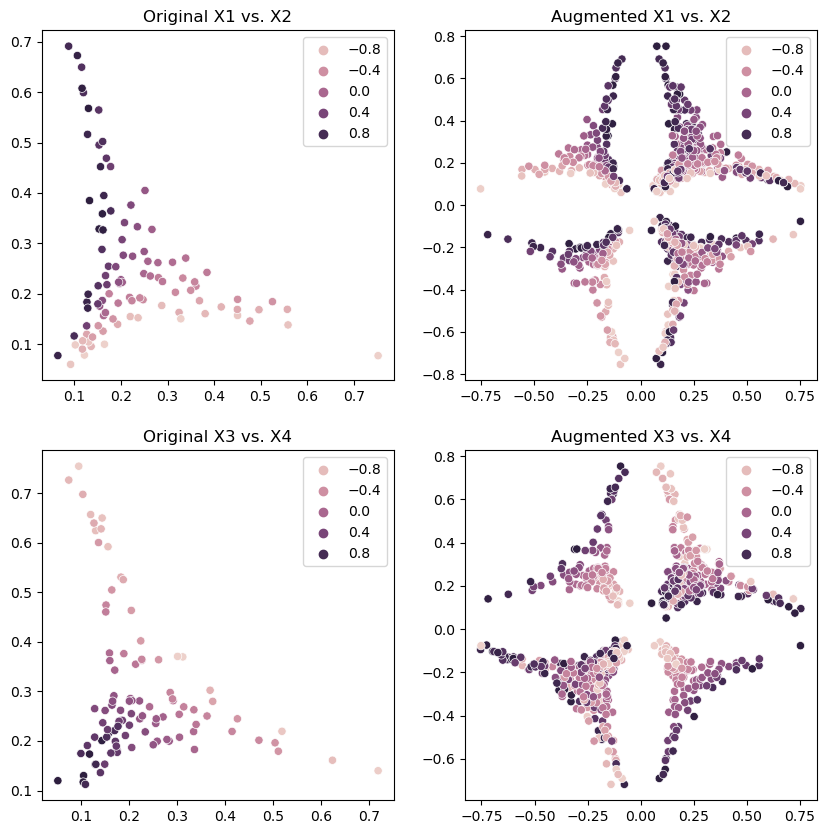

<IPython.core.display.Javascript object>

In [21]:
display_data(X_train_100, y_train_100, x_train_augmented, y_train_augmented)

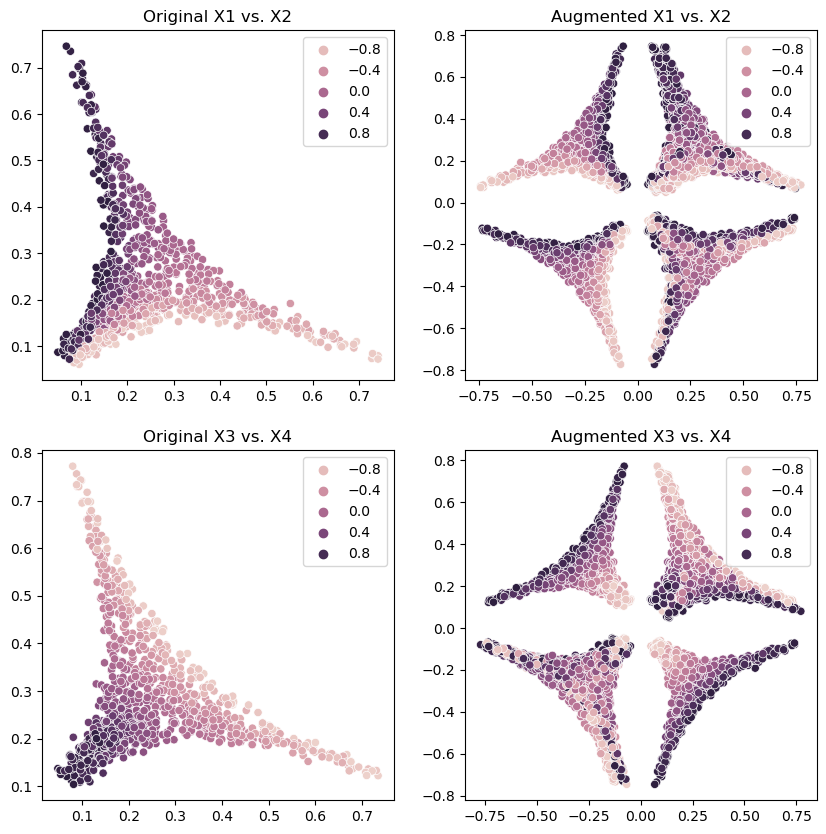

<IPython.core.display.Javascript object>

In [22]:
display_data(X_train_1000, y_train_1000, x_train_augmented_1000, y_train_augmented_1000)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def display_data_new(x_train, y_train, x_train_aug, y_train_aug, coeffs=None):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    
    # Scatter plots
    sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], hue=y_train[:, 0], s=50, ax=axes[0, 0])
    sns.scatterplot(x=x_train_aug[:, 0], y=x_train_aug[:, 1], hue=y_train_aug[:, 0], s=50, ax=axes[0, 1])
    sns.scatterplot(x=x_train[:, 2], y=x_train[:, 3], hue=y_train[:, 1], s=50, ax=axes[1, 0])
    sns.scatterplot(x=x_train_aug[:, 2], y=x_train_aug[:, 3], hue=y_train_aug[:, 1], s=50, ax=axes[1, 1])
    
    # Histograms
    sns.histplot(x=x_train[:, 0], kde=True, ax=axes[0, 2])
    sns.histplot(x=x_train[:, 1], kde=True, ax=axes[1, 2])
    
    # Decision boundary
    if coeffs is not None:
        x1 = np.linspace(-2, 2, 100)
        x2 = -(coeffs[0]*x1 + coeffs[2])/coeffs[1]
        axes[0, 0].plot(x1, x2, color='red')
                        
                        
        x2 = -(coeffs[0]*x1 + coeffs[2] - 1)/coeffs[1]
        axes[0, 0].plot(x1, x2, linestyle='dashed', color='green')
    
        axes[0, 0].legend(['Decision boundary', 'Margin', 'Margin'])

    # Set plot titles
    axes[0, 0].set_title('Original X1 vs. X2')
    axes[0, 1].set_title('Augmented X1 vs. X2')
    axes[1, 0].set_title('Original X3 vs. X4')
    axes[1, 1].set_title('Augmented X3 vs. X4')
    axes[0, 2].set_title('Histogram of X1 and X2')
    axes[1, 2].set_title('Histogram of X3 and X4')

    # Set plot labels
    axes[0, 0].set_xlabel('X1')
    axes[0, 0].set_ylabel('X2')
    axes[0, 1].set_xlabel('X1')
    axes[0, 1].set_ylabel('X2')
    axes[1, 0].set_xlabel('X3')
    axes[1, 0].set_ylabel('X4')
    axes[1, 1].set_xlabel('X3')
    axes[1, 1].set_ylabel('X4')
    axes[0, 2].set_xlabel('Value')
    axes[0, 2].set_ylabel('Frequency')
    axes[1, 2].set_xlabel('Value')
    axes[1, 2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()




<IPython.core.display.Javascript object>

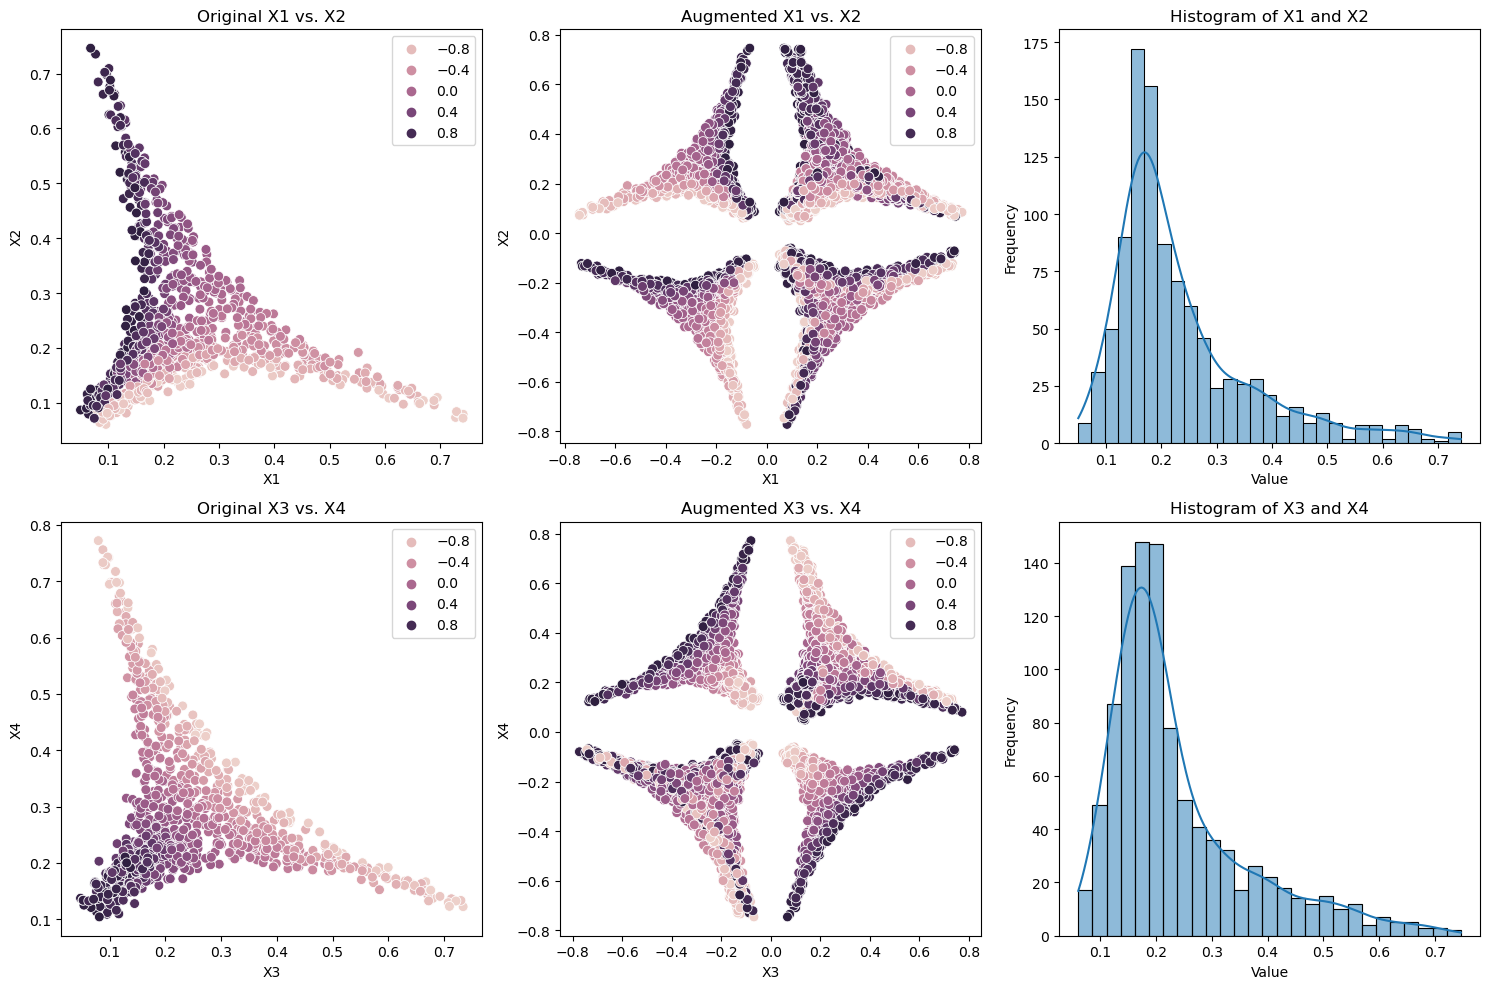

<IPython.core.display.Javascript object>

In [24]:
display_data_new(
    X_train_1000, y_train_1000, x_train_augmented_1000, y_train_augmented_1000
)

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA on the training data
pca = PCA()
X_train_100_pca = pca.fit_transform(X_train_100)

# Print the explained variance ratios for each principal component
print(pca.explained_variance_ratio_)


In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

In [ ]:
# pip install tf-nightly-gpu

In [ ]:
def standard_model(hp):
    model = Sequential()
    model.add(
        Dense(
            units=hp.Int("units_1", min_value=32, max_value=512, step=32),
            input_shape=(4,),
            activation=hp.Choice("activation_1", values=["relu", "tanh", "sigmoid"]),
        )
    )

    model.add(Dropout(hp.Float("dropout_1", min_value=0.2, max_value=0.5, step=0.1)))
    model.add(BatchNormalization())

    model.add(
        Dense(
            units=hp.Int(f"units_2", min_value=16, max_value=128, step=16),
            activation=hp.Choice(
                f"activation_2",
                values=["relu", "tanh", "sigmoid"],
            ),
        )
    )

    model.add(Dropout(hp.Float(f"dropout_2", min_value=0.2, max_value=0.5, step=0.1)))
    model.add(BatchNormalization())

    model.add(Dense(2, activation="softmax"))

    # Set optimizer and learning rate
    optimizer = hp.Choice("optimizer", values=["adam", "adagrad", "nadam", "rmsprop"])
    learning_rate = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4])

    if optimizer == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "adagrad":
        optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )

    # Add regularization
    if hp.Boolean("use_regularization"):
        l1_reg = hp.Float("l1_reg", min_value=1e-6, max_value=1e-2, sampling="log")
        l2_reg = hp.Float("l2_reg", min_value=1e-6, max_value=1e-2, sampling="log")
        model.add(keras.layers.ActivityRegularization(l1=l1_reg, l2=l2_reg))

    return model

In [ ]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Flatten(input_shape=(4,)))
        # Tune number of layers in NN
        for i in range(hp.Int("num_layers", 2, 8)):
            model.add(
                layers.Dense(
                    # Tune number of units separately.
                    units=hp.Int(f"units_{i}", min_value=64, max_value=512, step=64),
                    activation=hp.Choice("activation", ["sigmoid", "tanh", "relu"]),
                )
            )
        model.add(layers.Dense(2))
        # Tune Learning Rate
        learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        model.compile(
            #             optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            optimizer=hp.Choice(
                "optimizer", ["adam", "adadelta", "nadam", "RMSprop", "SGD"]
            ),
            loss=hp.Choice("loss", ["mean_absolute_error"]),
            metrics=[metrics.MeanAbsoluteError(name="my_mae")],
        )
        return model

    # Tune Model.fit parameters like batch size, epochs etc.
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            X_train,
            Y_train,
            batch_size=hp.Choice("batch_size", [50, 100]),
            epochs=hp.Choice("epochs", [50, 100]),
            **kwargs,
        )


tuner = kt.RandomSearch(
    MyHyperModel(),
    objective=kt.Objective("val_my_mae", direction="min"),
    max_trials=50,
    executions_per_trial=10,
    overwrite=True,
    directory="/kaggle/output/",
    project_name="tune_hypermodel",
)

In [ ]:
import numpy as np
import pandas as pd

# Load data
df_train = pd.read_csv('training_data.csv')
df_val = pd.read_csv('validation_data.csv')

# Define the malfunction threshold for x4
x4_threshold = np.mean(df_train['x4'])

# Create a new feature that captures the difference between x4 and the other sensors
df_train['x4_diff'] = np.where(df_train['x4'] > x4_threshold, df_train['x4'] - x4_threshold, 0)
df_val['x4_diff'] = np.where(df_val['x4'] > x4_threshold, df_val['x4'] - x4_threshold, 0)

# Scale the data to have zero mean and unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = df_train.drop(['y1', 'y2'], axis=1)
y_train = df_train[['y1', 'y2']]

X_val = df_val.drop(['y1', 'y2'], axis=1)
y_val = df_val[['y1', 'y2']]

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
